# Time Series forecasting with LSTM

## Table of content
1. [Libraries](#libraries)
2. [Read Data](#data)
3. [Feature Engineering](#feature)
4. [LSTM model](#lstm)
5. [PREDICTION](#prediction)

### Data <a id="data"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
import torch
from torch import nn
from torch.autograd import Variable as V
from torch import optim
import torchvision as tv
import torchvision.transforms as tf

### Read data<a id="data"></a>

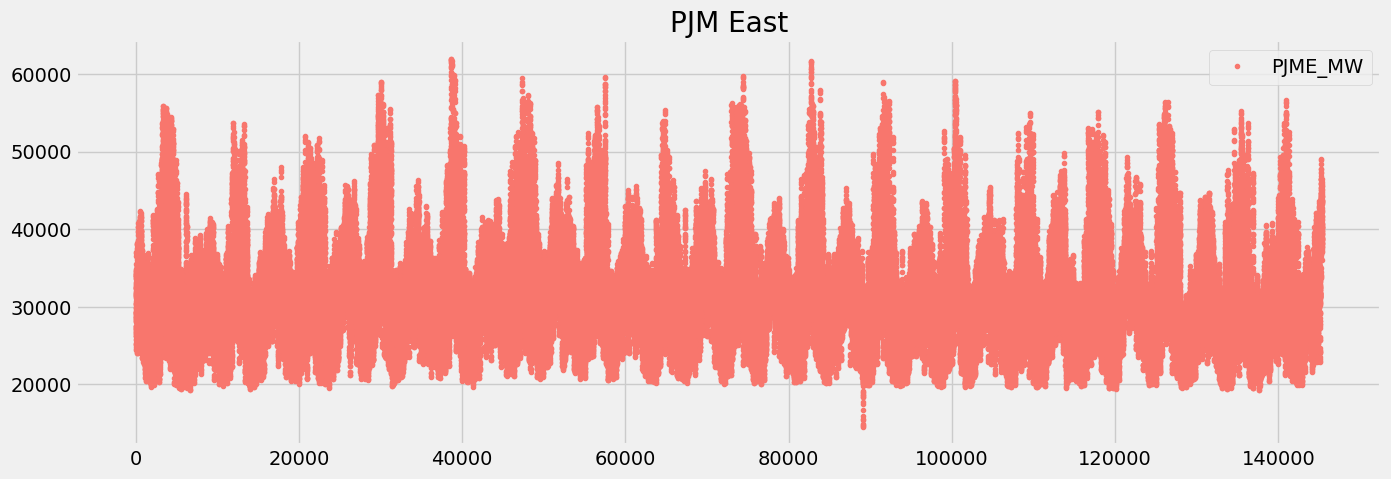

In [2]:
pjme = pd.read_csv('PJME_hourly.csv', usecols=[1])
color_pal ="#F8766D"
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal, title='PJM East')

### Feature Engineering<a id="feature"></a>

Trích xuất dữ liệu vào mảng dataset và biểu diễn

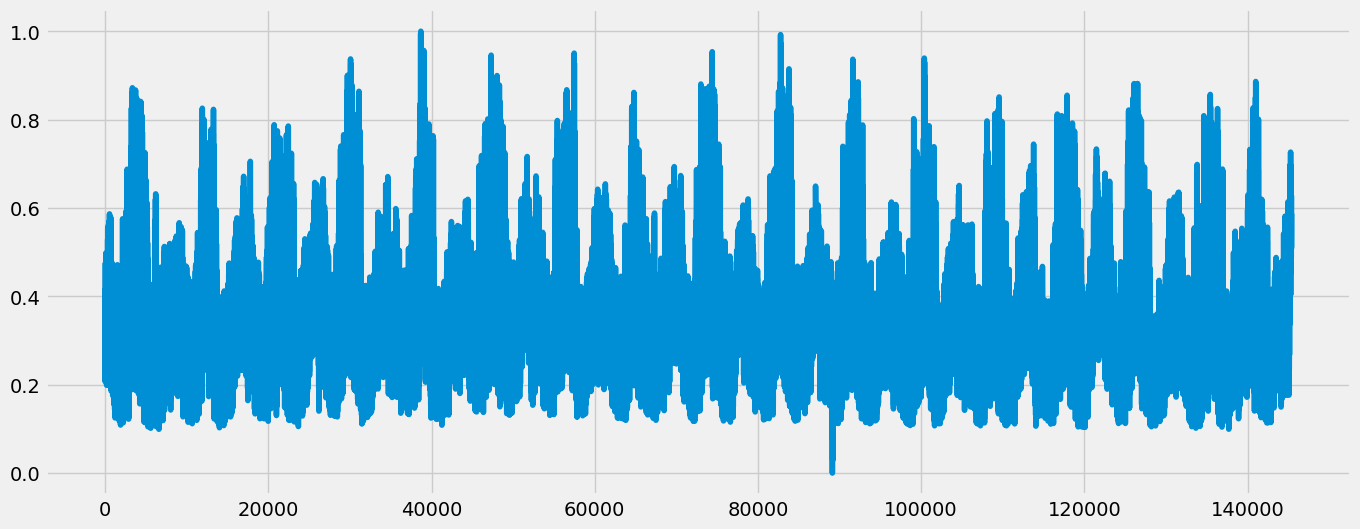

In [3]:
plt.figure(figsize=(15,6))
data_csv = pjme.dropna()
dataset = data_csv.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: (x-min_value) / scalar, dataset))
plt.plot(dataset)

### LSTM model<a id="lstm"></a>

In [4]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [5]:
look_back = 5
data_X, data_Y = create_dataset(dataset, look_back)

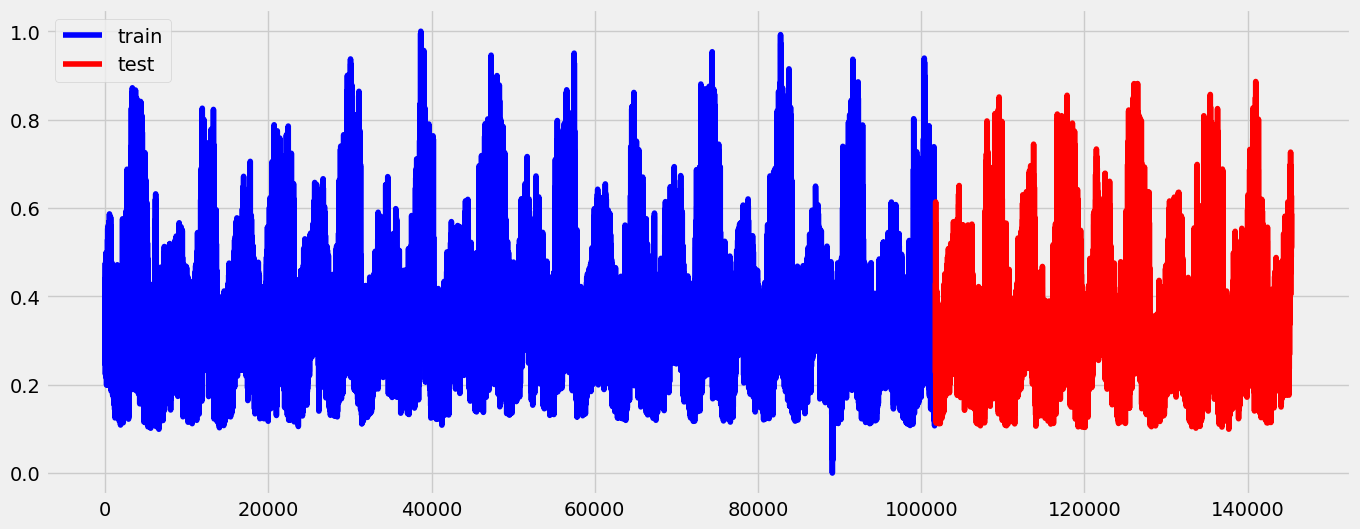

In [6]:
plt.figure(figsize=(15,6))
train_size = int(len(data_X) * 0.7)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]
x1=np.arange(0,101752)
x2 = np.arange(101752,145361)
plt.plot(x1,train_Y,'b',label='train')
plt.plot(x2, test_Y, 'r', label='test')
plt.legend(loc='best')

Tạo train là một đối tượng DataLoader có thể được sử dụng để lặp qua các batch dữ liệu trong quá trình huấn luyện mô hình.

In [7]:
train_X = train_X.reshape(-1, 1, look_back)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, look_back)
train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)
train=torch.zeros(len(train_x),1,look_back+1)
train[:,:,:look_back]=train_x
train[:,:,look_back:(look_back+1)]=train_y
train = torch.utils.data.DataLoader(
    train,
    batch_size=12719,
    shuffle=False,
    num_workers=2
    )

Tạo lớp RNN đại diện cho một mô hình mạng nơ-ron tái phát với tầng LSTM và một lớp tuyến tính

In [8]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1,num_layers=2):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(  
            input_size,
            hidden_size,  
             num_layers,  
        )
        self.reg = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        x,_=self.rnn(input)
        s,b,h=x.shape
        x=x.view(s*b,h)
        x=self.reg(x)
        x=x.view(s,b,-1)
        return x

In [9]:
rnn = RNN(look_back,4)
print(rnn)
optimizer=torch.optim.Adam(rnn.parameters(),lr=0.01)
criterion=nn.MSELoss()

RNN(
  (rnn): LSTM(5, 4, num_layers=2)
  (reg): Linear(in_features=4, out_features=1, bias=True)
)


In [10]:
for e in range(20):
    for i, data in enumerate(train, 0):
        var_x = V(data[:,:,:look_back])
        var_y = V(data[:,:,look_back:(look_back+1)])
        out = rnn(var_x)
        loss = criterion(out, var_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (e + 1) % 1 == 0: 
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

Epoch: 1, Loss: 0.01880
Epoch: 2, Loss: 0.01656
Epoch: 3, Loss: 0.01298
Epoch: 4, Loss: 0.01180
Epoch: 5, Loss: 0.00967
Epoch: 6, Loss: 0.00769
Epoch: 7, Loss: 0.00560
Epoch: 8, Loss: 0.00380
Epoch: 9, Loss: 0.00260
Epoch: 10, Loss: 0.00216
Epoch: 11, Loss: 0.00171
Epoch: 12, Loss: 0.00132
Epoch: 13, Loss: 0.00112
Epoch: 14, Loss: 0.00100
Epoch: 15, Loss: 0.00090
Epoch: 16, Loss: 0.00083
Epoch: 17, Loss: 0.00078
Epoch: 18, Loss: 0.00075
Epoch: 19, Loss: 0.00071
Epoch: 20, Loss: 0.00068


In [11]:
rnn = rnn.eval()

### PREDICTION<a id="prediction"></a>

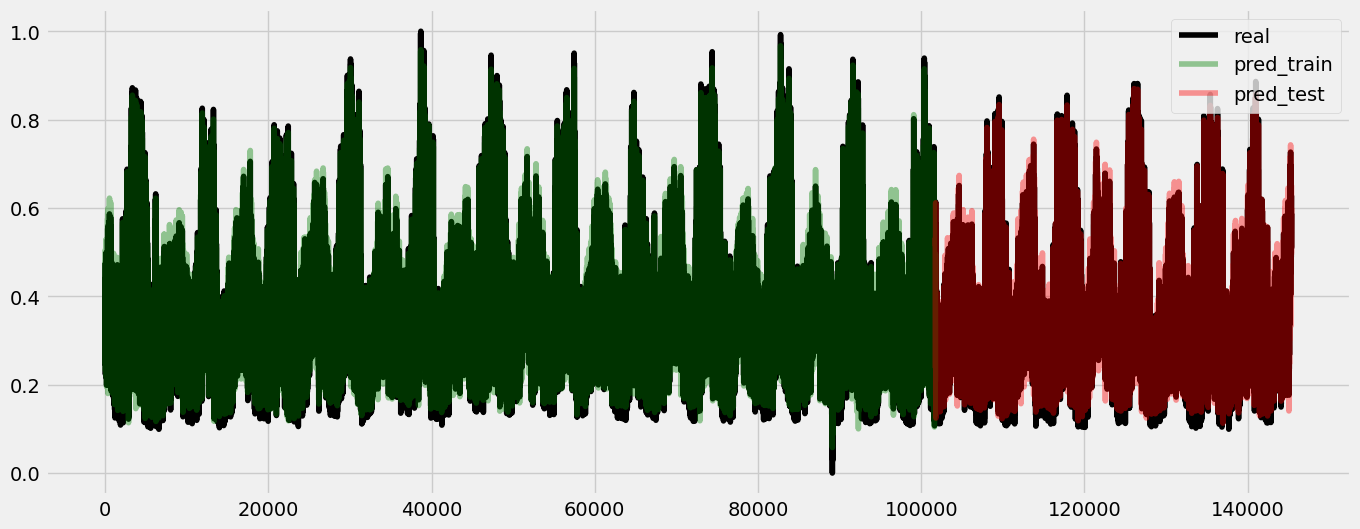

In [12]:
train_x = V(train_x)
outputs_train = rnn(train_x)
pred_train = outputs_train.view(-1).data.numpy()
inputs=V(test_x)
outputs=rnn(inputs)
predicted = outputs.view(-1).data.numpy()
plt.figure(figsize=(15,6))
plt.plot(data_Y, 'k', label='real')
plt.plot(pred_train, 'g' , label='pred_train',alpha=0.4)
plt.plot(x2,predicted,'r',label='pred_test',alpha=0.4)
plt.legend(loc='best')

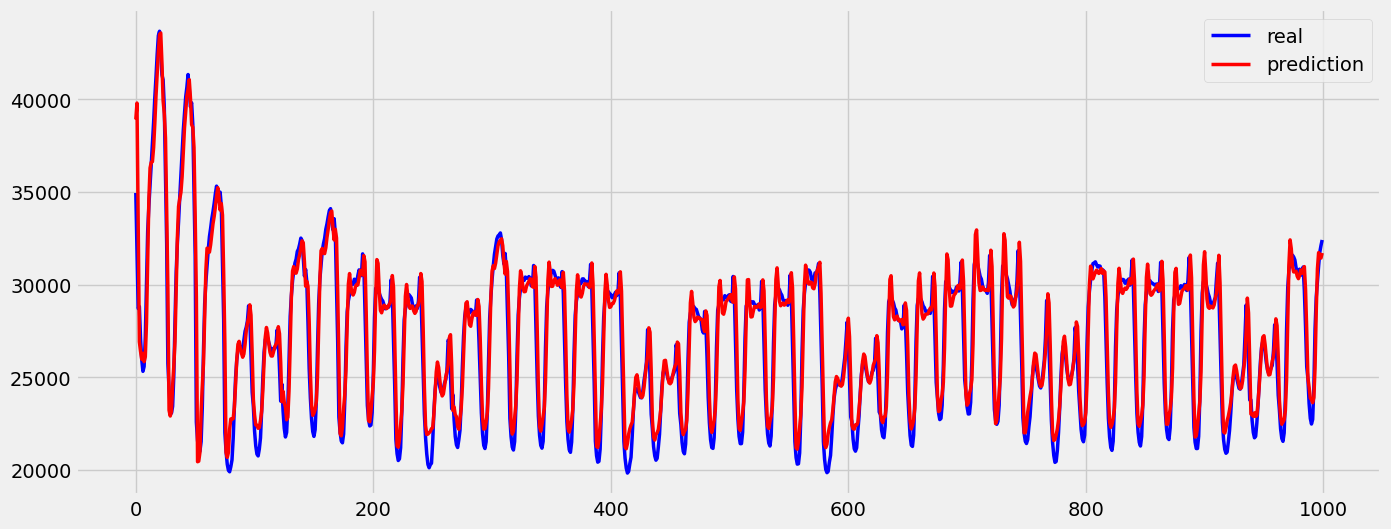

In [13]:
plt.figure(figsize=(15,6))
test_Y = list(map(lambda x: x*scalar+min_value , test_Y))
predicted = list(map(lambda x: x*scalar+min_value, predicted))
plt.plot(test_Y[0:1000], 'b', linewidth=2.5, linestyle="-",label='real')
plt.plot(predicted[0:1000], 'r',linewidth=2.5, linestyle="-", label='prediction')
plt.legend(loc='best')

In [14]:
def mean_absolute_percentage_error(y_true, y_pred):
    error=np.array(np.abs((y_true - y_pred) / y_true))
    return np.mean(error,axis=0) * 100

In [15]:
test_Y = np.array(test_Y).reshape(-1,1)
predicted = np.array(predicted).reshape(-1,1)
error=mean_absolute_percentage_error(y_true=test_Y,y_pred=predicted)
print('MAPE:%0.5f%%'%error)

MAPE:3.04344%


C:\Users\vudin\AppData\Local\Temp\ipykernel_11952\4102889479.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('MAPE:%0.5f%%'%error)
